# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

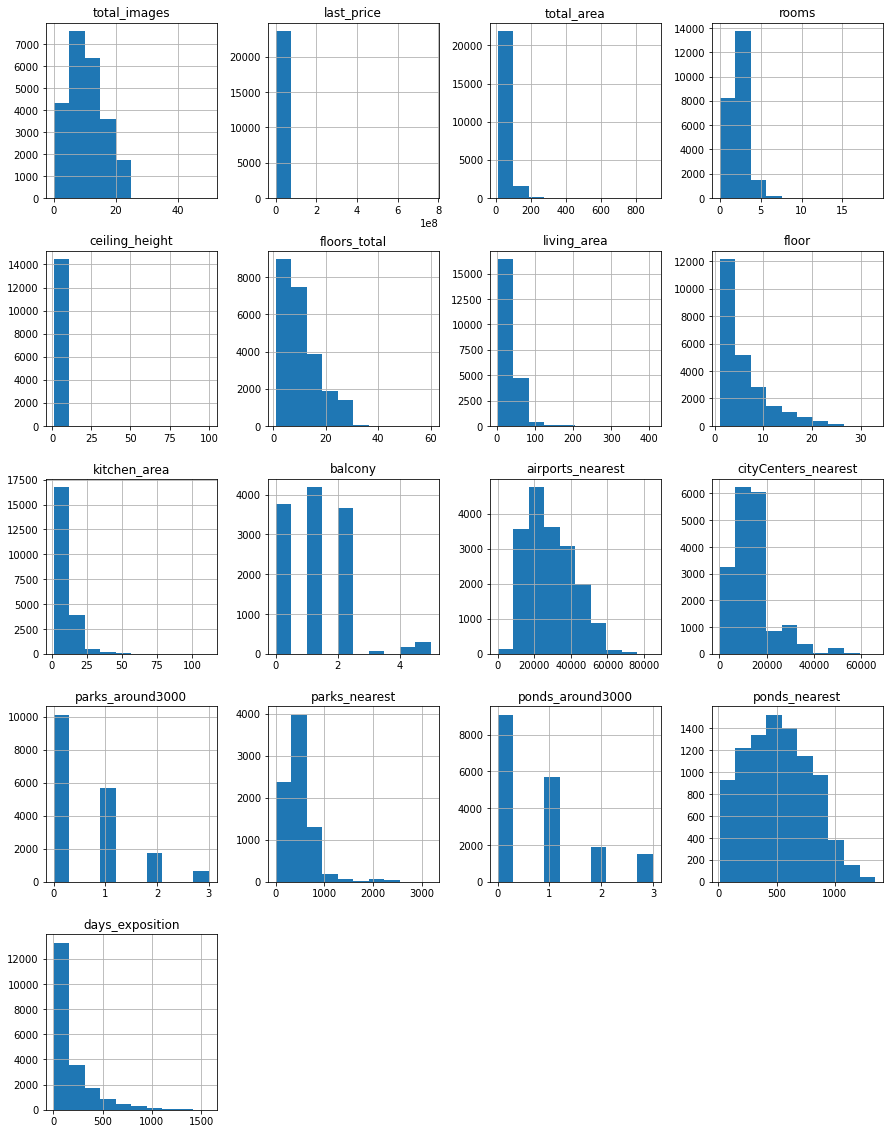

In [1]:
import pandas as pd 

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

data.info()
print(data.head())
data.hist(figsize=(15, 20));


В столбцах floors_total, balcony, parks_around3000, ponds_around3000 и days_exposition тип данных должны быть int, is_apartment - bool, а first_day_exposition - тип даты и времени
Переименуем столбец cityCenters_nearest в соответствии с нормами стиля
Также, видим, что во многих столбцах есть пропуски, они могут быть вызваны как человеческим фактором, так и технической ошибкой
Из полученных гистограм, видим, что с данными нужно работать, тк есть большое количество нулевых значений в показателе rooms или в balacony.

### Выполните предобработку данных

In [2]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True) #переименуем столбы в соответсвии с нормой

print(data.isna().sum())


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [3]:
data['balcony'] = data['balcony'].fillna(0) #заполняем балконы 0, тк их, вероятно, просто нет
data['is_apartment'] = data['is_apartment'].fillna('False') #заполняем пропуски false, тк эти квартиры не являются аппртаментам

In [4]:
#вероятно высота потолоков зависит от количества этажей в доме
dependence_of_height = data.pivot_table(index = 'floors_total', values='ceiling_height', aggfunc=['median', 'count'])
dependence_of_height.columns = ['median', 'count']
#заполним пропуски, значениями, характерными для дома с соответсвующим количеством этажей
for floors in dependence_of_height.index:
    data.loc[(data['ceiling_height'].isna()) & (data['floors_total'] == floors), 'ceiling_height'] = dependence_of_height.loc[floors, 'median']
print(data['ceiling_height'].isna().value_counts())

#осталось еще 78 пропущенных значенией, это значения в строках, в которых отсутствует информация о количестве этажей в доме
for floors in dependence_of_height.index:
    data.loc[(data['floors_total'].isna()) |
        ((data['floors_total'] == floors) & (dependence_of_height.loc[floors, 'count'] == 0)),
        'ceiling_height'] = data['ceiling_height'].describe()[5]

False    23621
True        78
Name: ceiling_height, dtype: int64


In [5]:
data = data.loc[(data['ceiling_height'] < 5) & (data['ceiling_height'] > 2.5)]#удаляем аномальные значения, где потолки выше 5м и ниже 2.5 м
data.dropna(subset=['floors_total'],inplace=True) #удаляем пропуски, тк их немного
data.dropna(subset=['locality_name'],inplace=True) #удаляем пропуски, тк их немного

In [6]:
#видим много пропущенных значений в жилой площади, заполним пропуски медианным значением для квартир с соответствующем количеством комнат
print(data.corr().sort_values(by='living_area')['living_area'])
dependence_of_area = data.pivot_table(index = 'rooms', values='living_area', aggfunc=['median'])
dependence_of_area.columns = ['median']
print(dependence_of_area.head(15))
for area in dependence_of_area.index:
    data.loc[(data['living_area'].isna()) & (data['rooms'] == area), 'living_area'] = dependence_of_area.loc[area, 'median']
print(data['living_area'].isna().value_counts())

city_centers_nearest   -0.242067
floors_total           -0.199256
floor                  -0.115678
ponds_nearest          -0.082460
studio                 -0.061671
airports_nearest       -0.058809
parks_nearest          -0.057255
open_plan              -0.036976
balcony                -0.026336
total_images            0.105808
days_exposition         0.148364
ponds_around3000        0.150114
parks_around3000        0.198446
ceiling_height          0.385837
kitchen_area            0.424995
last_price              0.563785
rooms                   0.851226
total_area              0.940784
living_area             1.000000
Name: living_area, dtype: float64
       median
rooms        
0       18.00
1       17.60
2       31.00
3       46.00
4       66.20
5       91.90
6      124.40
7      145.00
8      161.00
9      169.90
10     161.40
11     133.90
12     409.70
14     195.15
15     409.00
False    19939
Name: living_area, dtype: int64


In [7]:
print(data.corr().sort_values(by='kitchen_area')['kitchen_area']) #видим, что наибольшая зависимость площади кухни от общей площади
dependence_of_kitchen = data.pivot_table(index = 'total_area', values='kitchen_area', aggfunc=['median'])
dependence_of_kitchen.columns = ['median']
print(dependence_of_kitchen.head(15))

data.loc[data['studio'] == True, 'kitchen_area'] = 0 #примем за 0 площадь кухни в студи

for kitchen in dependence_of_kitchen.index:
    data.loc[(data['kitchen_area'].isna()) & (data['total_area'] == kitchen), 'kitchen_area'] = dependence_of_kitchen.loc[kitchen, 'median'] #заполняем пропуски медианным значением для квартир с соответствующей площадью
print(data['kitchen_area'].isna().value_counts())


city_centers_nearest   -0.176979
ponds_nearest          -0.098777
airports_nearest        0.027634
parks_nearest           0.030468
balcony                 0.041736
parks_around3000        0.088843
days_exposition         0.103509
floor                   0.107408
total_images            0.111509
floors_total            0.120821
ponds_around3000        0.137104
rooms                   0.285228
ceiling_height          0.311583
living_area             0.420884
last_price              0.511727
total_area              0.600512
kitchen_area            1.000000
studio                       NaN
open_plan                    NaN
Name: kitchen_area, dtype: float64
            median
total_area        
14.00         2.00
17.00         3.00
18.00         3.00
18.40         2.40
20.00         5.80
20.30         4.00
20.67        14.95
21.00         3.80
21.40         6.30
22.00         5.30
22.23         5.00
22.40         4.80
23.00         5.00
23.29         2.00
23.50         5.80
False    19785


In [8]:
data['parks_around3000'].fillna(0, inplace=True)
data['ponds_around3000'].fillna(0, inplace=True) #заполняем пропуски 0, тк веротянее всего, раз эти значения не были указаны, значит парков или прудов рядом нет

In [9]:
print(len(data['locality_name'].unique()))
data['locality_name'] = data['locality_name'].str.lower() #приводим все к нижнему регистру
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е') #заменяем ё на е
)
data['locality_name'] = (
    data['locality_name']
    .str.replace('поселок', 'поселок городского типа') #заменяем городской поселок на пгт
)
print('Количество явных дубликатов:', data.duplicated().sum()) #проверяем количество явных дубликатов
print()
print(data['locality_name'].unique())

344
Количество явных дубликатов: 0

['санкт-петербург' 'поселок городского типа шушары'
 'городской поселок городского типа янино-1'
 'поселок городского типа парголово' 'поселок городского типа мурино'
 'ломоносов' 'сертолово' 'петергоф' 'пушкин' 'деревня кудрово' 'коммунар'
 'колпино' 'гатчина' 'деревня федоровское' 'выборг' 'кронштадт' 'кировск'
 'деревня новое девяткино' 'поселок городского типа металлострой'
 'поселок городского типа городского типа лебяжье'
 'поселок городского типа молодцово'
 'поселок городского типа городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'кингисепп' 'сестрорецк' 'деревня куттузи'
 'поселок городского типа аннино'
 'поселок городского типа городского типа ефимовский'
 'поселок городского типа плодовое' 'деревня заклинье'
 'поселок городского типа торковичи'
 'поселок городского типа первомайское'
 'поселок городского типа понтонный' 'сясьстрой' 'деревня старая'
 'деревня лесколово' 'сланцы

In [10]:
print(data.describe())#видим минимальное значение в last_price ниже 100000, что похоже на выброс
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 100000')['last_price'].count()) #видим 1 квартиру
data.drop(index=data.query('last_price < 100000').index,inplace=True) #удаляем эту квартиру

       total_images    last_price    total_area         rooms  ceiling_height  \
count  19939.000000  1.993900e+04  19939.000000  19939.000000    19939.000000   
mean       9.872060  6.966924e+06     62.393050      2.078941        2.744438   
std        5.725404  1.167017e+07     37.535661      1.108963        0.229471   
min        0.000000  1.219000e+04     12.000000      0.000000        2.510000   
25%        6.000000  3.550000e+06     40.400000      1.000000        2.600000   
50%        9.000000  4.880000e+06     54.000000      2.000000        2.700000   
75%       14.000000  7.250000e+06     72.300000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000        4.900000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  19939.000000  19939.000000  19939.000000  19785.000000  19939.000000   
mean      11.207984     35.132759      6.139475     10.941009      0.599177   
std        6.842050     22.903984

In [11]:
#в total_area есть квартира площадью 12м, что не похоже на выброс, мб просто очень маленкая кваритра
#в rooms есть нуевые значения, однако вероятно это студии
#высоту потолков трогать не станем
#жилая площадь не может быть 2 метра, похоже на выброс
data.drop(index=data.query('living_area < 12').index,inplace=True) #убираем значения меньше 12м
#в площади кухни есть нулевые значения, но это, веротяно значения площади для студий, уберем все, что меньше 3кв метров
data.drop(index=data.query('kitchen_area < 3').index,inplace=True)
data.drop(index=data.query('rooms > 7').index,inplace=True) #это значение (больше 7 комнат) больше похоже на выброс
#данные, свидетельсвующие о ближайшем расположении инфраструктуры трогать не будем.

In [12]:
#приводим все данные к корректным форматам
import numpy as np
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #меняем формат даты
data["floors_total"] = data["floors_total"].astype('int')
data["parks_around3000"] = data["parks_around3000"].astype('int')
data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')
data['balcony'] = data['balcony'].astype('int')
data["ponds_around3000"] = data["ponds_around3000"].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['last_price'] = data['last_price'].astype('int')

Огромное спасибо за способ изменения типа данных!) 

In [13]:
print(data.info())
print()
print(data.isna().sum())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19644 entries, 0 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19644 non-null  int64         
 1   last_price            19644 non-null  int64         
 2   total_area            19644 non-null  float64       
 3   first_day_exposition  19644 non-null  datetime64[ns]
 4   rooms                 19644 non-null  int64         
 5   ceiling_height        19644 non-null  float64       
 6   floors_total          19644 non-null  int64         
 7   living_area           19644 non-null  float64       
 8   floor                 19644 non-null  int64         
 9   is_apartment          19644 non-null  bool          
 10  studio                19644 non-null  bool          
 11  open_plan             19644 non-null  bool          
 12  kitchen_area          19499 non-null  float64       
 13  balcony         

общий вывод.
высота потолков: были обработаны все пропущенные данные, они были заполнены мединанным значением характеным для домов, с опредленным количеством этажей, также были удалены аномальные значение с высотой потолков меньше 2 метров и выше 5. Ошибка в этих данных могла быть вызвана тем, что некоторые данные вносились вручную, когда люди хотели написать, например, 2,5 метра, они  писали 25 метров.

балконы: заполнили пропуски 0, тк, веротянее всего, продавцы просто не указали количество балконов потому что их нет

аппартаменты: заполнили пропуски false, т.к. в тех случаях, где не указано, что квартира является аппартаментом, 
можно считать, что она таковой не является

количество этажей и наименование местности: удаляем пропуски, тк пропущенных значений мало

жилая площадь: по аналогии с высотой потолков заменяем пропущенные значения медианным значением

площадь кухни: проводим анализ и замечаем, что наибольшая зависимость площади кухни, от общей площади, соответственно, заполняем пропуски медианным значением характерным для квартир с определенной общей площадью, а в квартирах-студиях, принимаем площадь кухни за 0

парки и пруды рядом с домом: заполняем пропуски 0, тк, веротяно, продавцы не указали наличие этих мест, тк их нет рядом

сколько дней было размещено объявление: пропусков в данных не так много, поэтому заменяем их медианным значением

исправляем в названиях населенных пунктов все ё на е, переименуем все поселки на пгт, а также приводим все к нижему регистру (на всякий случай)

приводим все данные к корректным форматам, для более удобного их восприятия, либо последующего использования

### Добавьте в таблицу новые столбцы

In [14]:
data['cost_per_sqm'] = data['last_price'] / data['total_area']

data['day_of_week'] = data['first_day_exposition'].dt.dayofweek
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

data.loc[data['floor'] == 1, 'floor_category'] = 'первый'    
data.loc[data['floor'] == data['floors_total'], 'floor_category'] = 'последний'
data.loc[data['floor_category'].isna(), 'floor_category'] = 'другой'

data['floor_category_int'] = data.apply(
    lambda x: 0 if (x.floor == 1) 
    else (2 if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 1), axis=1
)

data['nearest_cc_km'] = round(data['city_centers_nearest'] / 1000)
print(data.head(15))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20    13000000      108.00           2019-03-07      3   
1              7     3350000       40.40           2018-12-04      1   
2             10     5196000       56.00           2015-08-20      2   
3              0    64900000      159.00           2015-07-24      3   
4              2    10000000      100.00           2018-06-19      2   
5             10     2890000       30.40           2018-09-10      1   
7              5     7915000       71.60           2019-04-18      2   
8             20     2900000       33.16           2018-05-23      1   
10             5     5050000       39.60           2017-11-16      1   
11             9     3300000       44.00           2018-08-27      2   
12            10     3890000       54.00           2016-06-30      2   
13            20     3550000       42.80           2017-07-01      2   
14             1     4400000       36.00           2016-06-23   

### Проведите исследовательский анализ данных

       total_images    last_price    total_area         rooms  ceiling_height  \
count  19644.000000  1.964400e+04  19644.000000  19644.000000    19644.000000   
mean       9.893148  6.944765e+06     62.443191      2.087457        2.743913   
std        5.732159  1.121285e+07     36.025027      1.050323        0.229516   
min        0.000000  4.300000e+05     13.000000      0.000000        2.510000   
25%        6.000000  3.580000e+06     41.000000      1.000000        2.600000   
50%        9.000000  4.900000e+06     54.000000      2.000000        2.700000   
75%       14.000000  7.300000e+06     72.600000      3.000000        2.800000   
max       50.000000  7.630000e+08    631.200000      7.000000        4.900000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  19644.000000  19644.000000  19644.000000  19499.000000  19644.000000   
mean      11.162747     35.166048      6.119833     10.980913      0.598452   
std        6.813696     21.972281

<AxesSubplot:xlabel='nearest_cc_km'>

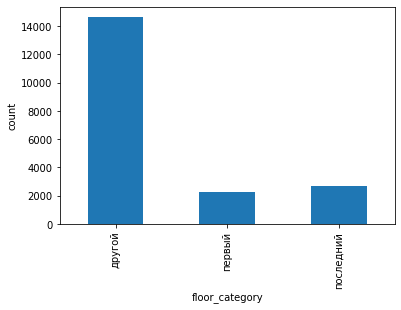

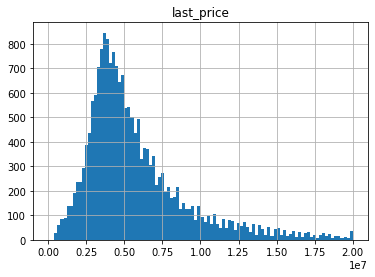

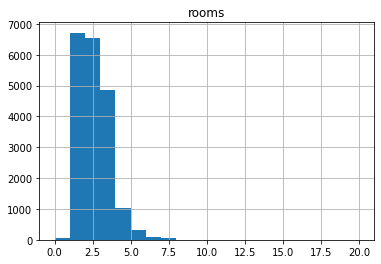

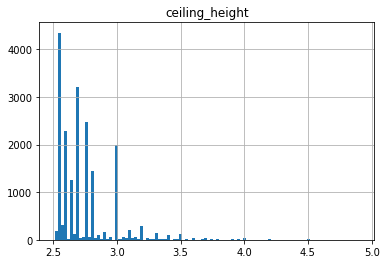

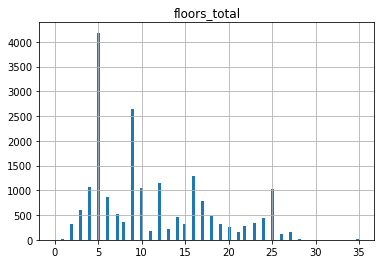

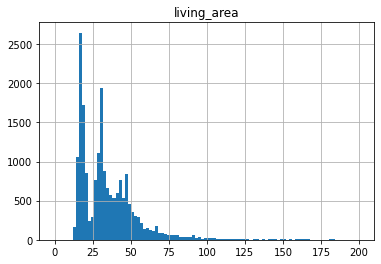

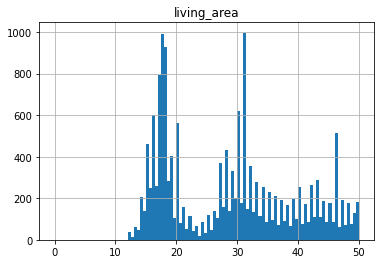

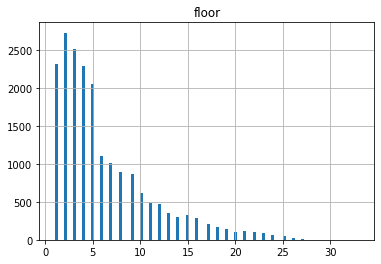

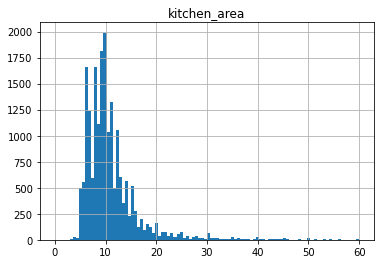

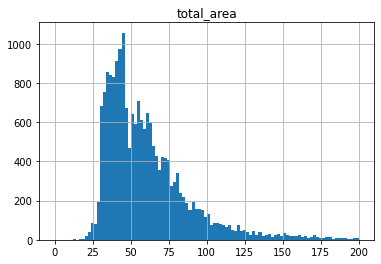

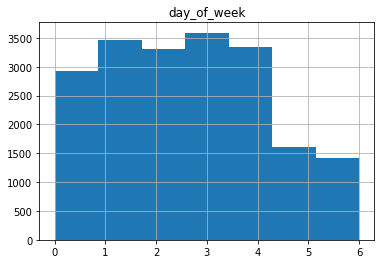

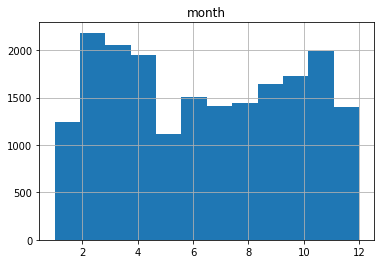

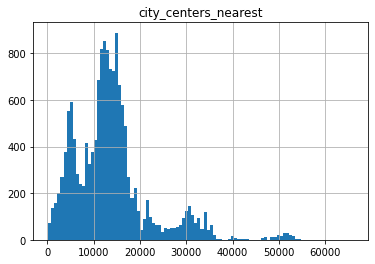

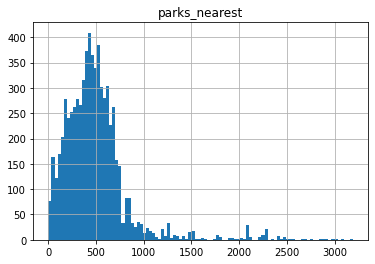

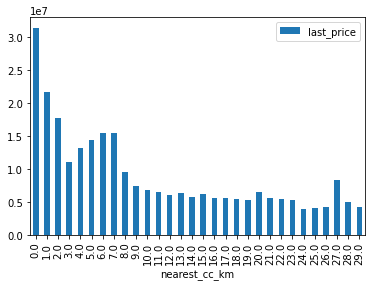

In [15]:
import matplotlib.pyplot as plt
print(data.describe())
data.groupby(by = 'floor_category')['floor_category'].count().plot(kind = 'bar',ylabel = 'count')
data.hist('last_price', bins = 100, range = (0,2e+07))
data.hist('rooms', bins = 20,range = (0,20))
data.hist('ceiling_height', bins = 100)
data.hist('floors_total', bins = 100, range = (0,35))
data.hist('living_area',bins = 100, range = (0,200))
data.hist('living_area',bins = 100, range = (0,50))
data.hist('floor', bins = 100)
data.hist('kitchen_area', bins = 100, range = (0,60))
data.hist('total_area',bins = 100, range = (0,200))
data.hist('day_of_week', bins=7)
data.hist('month', bins=12)
data.hist('city_centers_nearest', bins=100);
data.hist('parks_nearest', bins=100);

#этажи: больше всего этажей на "другом", что логично
#цена: график выглядит нормально, "хвост" справа это дорогая недвижимость
#комнаты: больше всего квартир, в которых 1-3 квартиры, однако встреачются и квартиры, в которых 4 комнаты
#высота потолков: в большинстве квартир потолки удерживаются на высоте 2,5 метров, на втором месте 2,65 метра, 
#а на 3 2,75 метра, также нередко встречаются кваритры с высотой потолков в 3 метра
#количество этажей: большинство домов 5-10 этажные, однако также часто как и 10 этажки, встречаются 25 этажные дома,
#вероятно это районы с новостройками
#жилая площадь: видим 2 пика, на 18 метрах и на 32/33 метрах, длинный хвост справа - элитная недвижимость
#этаж:видим явное преимущество квартир на 1-5 этажах, это объясняется тем, что большинство домов 5-10 этажные
#площадь кухни: пик на 10 метрах, хвост справа - элитная недвижимость
#общая площадь: явное преимущество у кваритр до 50 метров
#расстояние до центра: видим 3 пика на 5км, на 12 км и на 15 км
#расстояние до парка: судя по графику больше всего квартир с парками на расстоянии до 750м, а чаще всего квартиры 
#встречаются с расстоянием до парка в 400м
#день и месяц: реже всего квартиры выставляют на продажи в сб и вск, также видим провал в продажах в мае, декабре и январе


(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='nearest_cc_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)
#из графика видно, что стоимость кваритр выше всего на расстоянии до 1км, цены на расстоянии от 1 до 7 км ниже, 
#чем стомость до 1 км, чем дальше от центра, тем ниже цена, видим пик на 27км, но это веротяно, какой-то элитный район


Среднее время продажи квартиры в днях: 183, а медианное: 97.0 дней


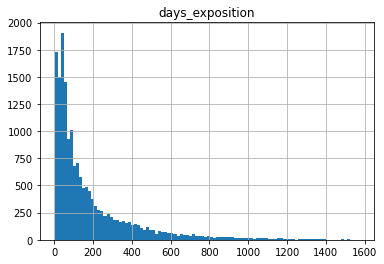

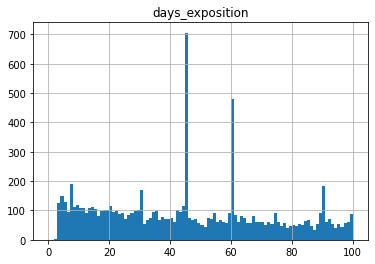

In [16]:
#как быстро продовались квартиры
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins = 100, range = (0,100))
print('Среднее время продажи квартиры в днях: {0}, а медианное: {1} дней'.format(int(data['days_exposition'].mean()),data['days_exposition'].median()))
#видим, что среднее время продажи квартиры 172,5 дня, но медианное 97 дней.  Такая разница объясняется тем,
#что у нас есть квартиры, корторые продавались годами.
#я бы стал считать, что быстые продажи - продажи до 97 дней, а долгие - свыше 173 дней

In [17]:
list = ['total_area', 'living_area', 'kitchen_area', 'rooms']
for g in list:
    correlation = data['last_price'].corr(data[g])
    print(f'Корреляция между last_price и {g} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 63.97%
Корреляция между last_price и living_area составляет: 54.18%
Корреляция между last_price и kitchen_area составляет: 50.82%
Корреляция между last_price и rooms составляет: 36.11%


<AxesSubplot:xlabel='rooms'>

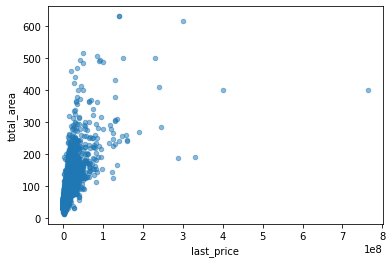

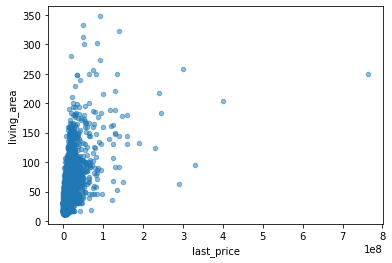

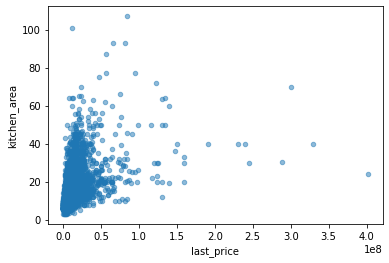

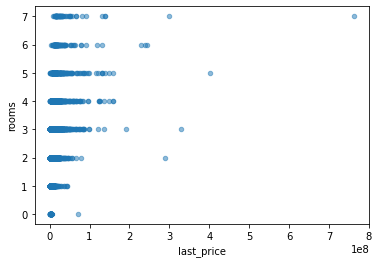

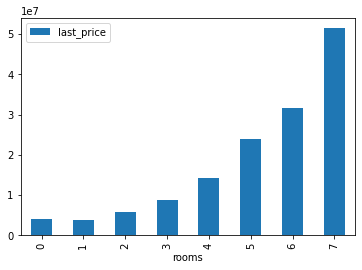

In [18]:
#строим графики для визуализации зависимости цены от других факторов
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.5)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.5)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.5)
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.5)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar')
#цена зависит от общей площали, жилой площади, площади кухни и количества комнат. В наибольшой степени зависит от общей площади.
#в наименьшей от  количества комнат


In [19]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum', 'total_area_sum','last_price_count','total_area_count']
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10['price_per_sqm'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.reset_index()
top_10_s=top_10.head(10)
print(top_10_s.sort_values(by='price_per_sqm'))
#среди 10 представленных населенных пунктов, видим, что наибольшая стоимость кв метра в санкт-петербурге, а наименьшная в выборг

                                   last_price_sum  total_area_sum  \
locality_name                                                       
выборг                                  652687000        11214.96   
всеволожск                             1393591965        20476.23   
гатчина                                 846479360        12304.98   
колпино                                 924140246        12478.52   
поселок городского типа шушары         1671441999        22033.11   
поселок городского типа мурино         1909791430        23124.12   
поселок городского типа парголово      1370871459        15818.60   
деревня кудрово                        1238123220        13631.15   
пушкин                                 2015940264        18847.28   
санкт-петербург                      113053376258       892740.50   

                                   last_price_count  total_area_count  \
locality_name                                                           
выборг                   

<AxesSubplot:xlabel='nearest_cc_km'>

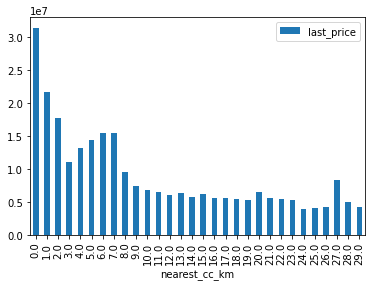

In [20]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='nearest_cc_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)
#из графика видно, что стоимость кваритр выше всего на расстоянии до 1км, цены на расстоянии от 1 до 7 км ниже, 
#чем стомость до 1 км, чем дальше от центра, тем ниже цена, видим пик на 27км, но это веротяно, какой-то элитный район


### Напишите общий вывод

После того, как мы получили данные и изучили их, было необходимо обработать выбросы и исправить пропуски в таблицах. Например, в нашем случае, были квартиры с высотой потолков выше 5 метров, квартиры с более чем 7 комнатами, была очень дешевая квартира, все эти данные были исправлены
Можно отметить, что самые дорогие квартиры расположены в санкт-петербурге, пушкине, деревне кудрово, пгт парголово, пгт мурино и пгт шушары
Больше всего квартир продают не на 1 и не на последних этажах
Большинство квартир имеют 1-3 комнаты
Средняя высота потолков варируется от 2,6 до 3м
В основном выставляются на продажу квартиры, в которых 5 этажей
Наибольшее количество объявлений в квартирах, в которых жил площаль 18 или 33 кв. метров
В показателях площади (кухни, общей или жилой) характерен большой хвост справа, это обусловлено тем, что на продажу также выставляется элитная недвижимость
Наибольшая зависимость стоимости квартиры от площади, а наименьшая от количества комнат, хотя она тоже значимая
Быстрыми продажами принял считать продажи до 97 дней, а долгими свыше 173 дней
Также стоит отметить, что самые дорогие квартиры расположены на расстоянии до 1км от питера, а чем больше удаленность от центра, тем ниже цена, но на расстоянии 27км, стоимость квартир почти такая же, как на расстоянии 8 км от центра

не очень понял пункт про корреляцию для времени, я ее удалил и оставил только комнаты и площадь, она тоже не нужна? Вывод я закомментировал. А еще было бы очень здорово, если бы ты написал мне строчку кода для вывода bar plot для зависимоти цены от категориальных перменных)
Код поправил. Забыл, что из-за пропусков тип не поменялся, еще раз спасибо за способ)

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.